<a href="https://colab.research.google.com/github/VictorUceda/TrackNet-Padel/blob/main/Analisis_hits_padel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
input_name = 'FinalQatar_PremierPadel_Trim'# 'punto_qatar'#

#Inicialización de datos

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


import os 
# path = '/content/gdrive/MyDrive/Colab Notebooks/TrackNetv2/3_in_3_out'
path = '/content/gdrive/MyDrive/PadelData/'
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')
!pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


In [79]:
import numpy as np
pista_campo_fondo = np.array([np.array([390,213]), np.array([890,213]),np.array([965,350]), np.array([315,350])])
pista_campo_cerca = np.array([[315,350], [965,350],[1114,622],[162,618]])
pista_aristas = np.array([[390,213], [890,213],[1114,622],[162,618]])
linea_saque_fondo = 250
linea_saque_cerca = 518
red_bajo = 350
red_alto = 300
pista_campo_fondo

array([[390, 213],
       [890, 213],
       [965, 350],
       [315, 350]])

In [83]:
import pickle
with open(input_name+'.playersbox', "rb") as fp:  
  person_results = pickle.load(fp)

import pickle
with open(input_name+'.ballpos', "rb") as fp:  
  ball_pos = pickle.load(fp)
#print(ball_pos)
if input_name[-11:] == 'punto_qatar':
  del ball_pos[272] #outlier
  del ball_pos[71] #outlier
  del ball_pos[72] #outlier
  del ball_pos[73] #outlier

def calc_ball_speed(ball_pos):
  last_f, last_pos = 0,[]
  for f, pos in ball_pos.items():
    if f-last_f < 10 and last_pos != []:
      vel = [pos[0][0] - last_pos[0][0], pos[0][1] - last_pos[0][1]]
      vel = [v/ (f-last_f) for v in vel]
      pos[0].append(vel)
    last_f, last_pos = f, pos
calc_ball_speed(ball_pos)

#Analisis

In [84]:
print(len(person_results))
print(len(ball_pos))

1391
547


In [85]:
import numpy as np
import cv2

def plot_court(img):
  vis_img = cv2.polylines(img, np.int32([pista_campo_fondo]), True, (255,150,255),3)
  vis_img = cv2.polylines(img, np.int32([pista_campo_cerca]), True, (255,70,255),3)
  return vis_img

image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img.png')
cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img_court.png', plot_court(image))

True

In [86]:
import numpy as np
import matplotlib.path as mpltPath
import math
import random
def rectangle_dist(bbox1, bbox2):
  if len(bbox1)>=4 and len(bbox2)>=4:
    c1 = [(bbox1[0]+bbox1[2])/2, (bbox1[1]+bbox1[3])/2]
    c2 = [(bbox2[0]+bbox2[2])/2, (bbox2[1]+bbox2[3])/2]
    d =  math.sqrt( (bbox2[0] - bbox1[0])**2 + (bbox2[1] - bbox1[1])**2 )
    d += math.sqrt( (bbox2[0] - bbox1[0])**2 + (bbox2[3] - bbox1[3])**2 )
    d += math.sqrt( (bbox2[2] - bbox1[2])**2 + (bbox2[1] - bbox1[1])**2 )
    d += math.sqrt( (bbox2[2] - bbox1[2])**2 + (bbox2[3] - bbox1[3])**2 )
    if d == 0:
      return d+random.random()/100
    return d/4
  elif len(bbox1)>=2 and len(bbox2)>=2:
    c1, c2 = bbox1, bbox2
    return math.sqrt( (c2[0] - c1[0])**2 + (c2[1] - c1[1])**2 )
  else:
    return None

pista = mpltPath.Path(pista_aristas)
#pista_c0 = mpltPath.Path(pista_campo_cerca)

def persons_in_court(persons, pista):
  players=[]
  for i in range(len(persons)):
    p = persons[i]
    if pista.contains_points([[p['bbox'][2],p['bbox'][3]]]) or \
        pista.contains_points([[p['bbox'][0],p['bbox'][3]]]):
      players.append(i)
      if len(players) == 4:
        break
  return [persons[i]['bbox'] for i in range(len(persons)) if i in players], \
          [persons[i]['bbox'] for i in range(len(persons)) if i not in players]

#players_box = []
#for f in person_results:
#  players_box.append(persons_in_court(f, pista))
#print(players_box)
  #print(p['bbox'])

#cv2.putText(img, str(i), (p['bbox'][0],p['bbox'][3]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (10, 255, 0), 1, cv2.LINE_AA)
#players_box
#cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img_court.png', img)
#path.contains_points([(100,100)])

### Track jugador cercano

In [87]:

import copy
def identify_players(persons, last_players, pista, debug = False):
  distances = []
  if len(persons) == 0:
    return []
  
  p_in_court, p_not_in_court = persons_in_court(persons, pista)
  if debug: print("--->debug call identify_players")
  if debug: print(len(last_players))
  if len(last_players) == 0:
    return [np.append(p_in_court[i], int(i)) for i in range(len(p_in_court))]
  
  players = []
  
  if len(p_in_court) > 0: #Asignar los jugadores dentro de la pista con su posición previa más cercana
    candidates = p_in_court
    distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    while distances_m.size >0 and len(players) < 4 and distances_m.min() < 30:
      if debug: print(distances_m)
      distances_min = distances_m.min()
      if debug: print(distances_min)
      ij_min = np.where(distances_m == distances_min)
      
      (i_min,j_min) = tuple([i.item() for i in ij_min])

      pl = candidates[j_min] 
      pl = np.append(pl, last_players[i_min][5])
      pl = np.append(pl, distances_min)
      players.append(pl)
      if debug: print("player "+str(pl[5])+" localizado dentro de pista")
      if debug:print(last_players[i_min])
      if debug:print(candidates[j_min])
      #if debug:print((i_min,j_min))
      #distances_m = np.delete(distances_m, i_min, 0)
      #distances_m = np.delete(distances_m, j_min, 1)
      del last_players[i_min]
      del candidates[j_min]
      distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    if len(last_players) == 0:
      while len(p_in_court) > 0 and len(players) < 4: #nuevos jugadores
        new_id = [i for i in range(4) if i not in [p[5] for p in players]][0]
        pl = np.append(p_in_court[0], new_id)
        pl = np.append(pl, -1)
        players.append(pl)
        if debug: print("nuevo player "+str(pl[5])+" detectado")
        del p_in_court[0]
  
  candidates = p_not_in_court
  if len(candidates) > 0 and len(last_players) > 0 and len(players) < 4: #buscar jugadores fuera de pista
    distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    while distances_m.size >0 and len(players) < 4 and distances_m.min() < 30:
      distances_min = distances_m.min()
      ij_min = np.where(distances_m == distances_min)
      
      #print(distances_min)
      i_min, j_min = tuple([i.item() for i in ij_min])

      pl = candidates[j_min] 
      pl = np.append(pl, last_players[i_min][5])
      pl = np.append(pl, distances_min)
      players.append(pl)
      if debug: print("player "+str(pl[5])+" localizado dentro de pista")
      if debug:print(last_players[i_min])
      if debug:print(candidates[j_min])
      #if debug:print((i_min,j_min))
      #distances_m = np.delete(distances_m, i_min, 0)
      #distances_m = np.delete(distances_m, j_min, 1)
      del last_players[i_min]
      del candidates[j_min]
      distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    
  return players


players_box = [[]]
for i in range(len(person_results)):
  players_box.append(identify_players(copy.deepcopy(person_results[i]), copy.deepcopy(players_box[-1]) if len(players_box)>0 else [], pista, False))
#  print("players frame "+str(i)+":")
#  print(players_box[i])
#print(players_box[1351])
#print(players_box[1352])
#print(max([max([p[-1] for p in per]) for per in players_box if per != []]))

### Procesado de pista y detector de plano central

In [88]:
import math
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow # for image display

import matplotlib.pylab as plt


t_points = [[637, 251], [637, 518], 25]

def avg(lst):
    return sum(lst)/len(lst)

def group_similar_lines(lines, v_h = 0):
  res_lines = []
  for l in lines:
    dist = [[abs((l[0+v_h]+l[2+v_h])/2 - avg([(s[0+v_h]+s[2+v_h])/2 for s in res_lines[i]])) , i] for i in range(len(res_lines))]
    if dist != []:
      dist.sort(key=lambda a: a[0])
      if dist[0][0] < 5:
        res_lines[dist[0][1]].append(l)
      else:
        res_lines.append([l])
    else:
      res_lines.append([l])
  res = []
  for g in res_lines:
    x = int(round(avg([(l[0+v_h]+l[2+v_h])/2 for l in g]), 0))
    width = max([max(l[0+v_h],l[2+v_h]) for l in g]) - min([min(l[0+v_h],l[2+v_h]) for l in g])   
    y_min = int(round(min([min([l[1-v_h],l[3-v_h]]) for l in g]), 0))
    y_max = int(round(max([max([l[1-v_h],l[3-v_h]]) for l in g]), 0))
    if v_h==0: #vertical line
      res.append([x, y_min, x, y_max, width])
    else: #horizontal line
      res.append([y_min, x, y_max, x, width])
  return res

def line_intersection_vh(line_v, line_h):
    if line_v[0] <= max(line_h[0], line_h[2]) and \
        line_v[0] >= min(line_h[0], line_h[2]) and \
        line_h[1] <= max(line_v[1], line_v[3]) and \
        line_h[1] >= min(line_v[1], line_v[3]):
      return [line_v[0], line_h[1]]
    return None

def is_central_camera(img, search_intersection=False, plot=False):
  thresh, img_bin = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
  scale = 0.4
  img_bin = cv2.resize(img_bin, (int(img.shape[1]*scale), int(img.shape[0]*scale)), interpolation = cv2.INTER_AREA) # resize image
  dst = cv2.Canny(img_bin, 50, 200, None, 3)
   
  # Copy edges to the images that will display the results in BGR
  #cdst = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  cdst = np.copy(img)
  #cv2_imshow( cdstP)
    
  #lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
    
  #if lines is not None:
  #  for i in range(0, len(lines)):
  #    rho = lines[i][0][0]
  #    theta = lines[i][0][1]
  #    a = math.cos(theta)
  #    b = math.sin(theta)
  #    x0 = a * rho
  #    y0 = b * rho
  #    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
  #    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
  #    cv.line(cdst, pt1, pt2, (0,255,0), 3, cv.LINE_AA)

  linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)
  instersection = []
  if linesP is not None:
    linesP = [[e/scale for e in line] for line in linesP]
    h_lines = [l[0] for l in linesP if abs(l[0][1]-l[0][3])<3]
    v_lines = [l[0] for l in linesP if abs(l[0][0]-l[0][2])<3]
    
    v_lines = group_similar_lines(v_lines)
    h_lines = group_similar_lines(h_lines, 1)
    
    if plot:
      for i in range(0, len(v_lines)):
        #print(linesP[i])
        l = v_lines[i]
        cdst = cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,255,100), 3, cv2.LINE_AA)
        #cv2.putText(img, str(i), (l[2], l[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,100), 2, cv2.LINE_AA)
      for i in range(0, len(h_lines)):
        #print(linesP[i])
        l = h_lines[i]
        cdst = cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv2.LINE_AA)
        #cv2.putText(img, str(i), (l[2], l[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
        #print(v_lines)
    if search_intersection:
      for v in v_lines:
        for h in h_lines:
          instersection.append(line_intersection_vh(v, h))
      instersection = [i for i in instersection if i]
      if instersection != []:
        t_point_detected = 0
        for p in instersection:
          cv2.circle(img, (int(p[0]), int(p[1])), 8, (0,0,255), -1)
          if rectangle_dist(p, t_points[0]) < t_points[2] or \
              rectangle_dist(p, t_points[1]) < t_points[2]:
              t_point_detected +=1
        #print(t_point_detected)
        cv2_imshow(img)
        if t_point_detected >= 2:
          return img, True
    else: # search lines
      found_v, found_h = False, False
      for v in v_lines:
        if v[0] < t_points[0][0]+ t_points[2] and \
           v[0] > t_points[0][0] - t_points[2] and \
           abs(v[3]-v[1]) > 100:
           found_v = True
           break
      for h in h_lines:
        if ((h[1] < t_points[0][1]+ t_points[2] and \
           h[1] > t_points[0][1] - t_points[2]) or \
           (h[1] < t_points[1][1]+ t_points[2] and \
           h[1] > t_points[1][1] - t_points[2])) and \
           abs(h[2]-h[0]) > 100:
           found_h = True
           break
      if found_v and found_h:
        return img, True
  return cdst, False


## Analisis golpes

### Analisis punto_qatar

True
[12, 18, 25, 31, 36, 38, 41, 43, 65, 72, 74, 76, 79, 105, 111, 117, 139, 146, 173, 178, 186, 192, 205, 211, 220, 225, 231, 241, 246, 251, 254, 257, 294, 323, 325, 333, 335, 339, 342, 345, 347, 356, 359, 363, 369, 374, 377, 390, 403, 408, 414, 427, 431, 434, 439, 457, 461, 463, 467, 498, 526]
[(0, 1.0), (1, 6.708203932499369), (2, 0.0), (3, 4.0), (4, 6.4031242374328485), (5, 3.0), (6, 2.8284271247461903), (7, 5.656854249492381), (8, 6.324555320336759), (9, 4.47213595499958), (10, 7.280109889280518), (11, 10.816653826391969), (12, 11.40175425099138), (13, 11.40175425099138), (14, 11.661903789690601), (15, 16.1245154965971), (16, 11.661903789690601), (17, 18.439088914585774), (18, 18.973665961010276), (19, 17.08800749063506), (20, 22.090722034374522), (21, 434.62282498736766), (22, 447.4382638979371), (23, 59.77457653551382), (24, 33.96292095800949), (25, 14.317821063276353), (26, 11.661903789690601), (27, 67.90066273608822), (28, 138.11792968329638), (29, 14.981470036162822), (30, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


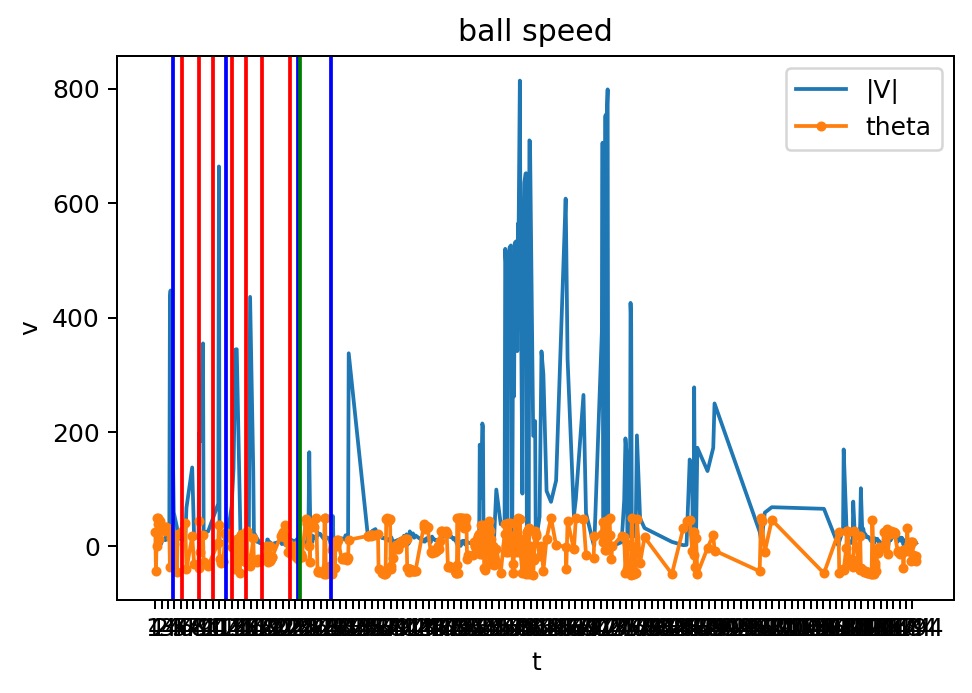

In [90]:
import cmath
hits = [46, 73, 94, 125, 147, 171, 215]
wall = [231]
bounce = [32, 115, 229, 280]
ball_t = [int(t) for t in ball_pos.keys() if len(ball_pos[t][0])>2]
ball_v_x = [ball_pos[t][0][2][0] for t in ball_t if len(ball_pos[t][0])>2]
ball_v_y = [ball_pos[t][0][2][1] for t in ball_t if len(ball_pos[t][0])>2]
ball_v = [math.sqrt(x*x+y*y) for x,y in zip(ball_v_x, ball_v_y)]
ball_o = [cmath.polar(complex(x,y))[1]*100/(2*math.pi) for x,y in zip(ball_v_x, ball_v_y)]

to_delete = []

for i in range(1,len(ball_t)-1):
  if i==43: print(ball_v[i] < ball_v[i-1]-8 and ball_v[i] < ball_v[i+1]-8)
  if ball_v[i] < ball_v[i-1]-8 and ball_v[i] < ball_v[i+1]-8:
    to_delete.append(i)
print(to_delete)

ball_t = [ball_t[i] for i in range(len(ball_t)) if i not in to_delete]
ball_v_x = [ball_v_x[i] for i in range(len(ball_v_x)) if i not in to_delete]
ball_v_y = [ball_v_y[i] for i in range(len(ball_v_y)) if i not in to_delete]
ball_v = [ball_v[i] for i in range(len(ball_v)) if i not in to_delete]
ball_o = [ball_o[i] for i in range(len(ball_o)) if i not in to_delete]


print(list(zip(range(len(ball_v)), ball_v)))


import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180

radians = True
if radians:
  plt.plot(ball_t, ball_v, label="|V|")
  plt.plot(ball_t, ball_o, label="theta", marker='.')
else:
  plt.plot(ball_t, ball_v_x, label="V_x", marker='.')
  plt.plot(ball_t, ball_v_y, label="V_y", marker='x')
plt.xticks(np.arange(min(ball_t), max(ball_t)-1, 10))
for b in bounce:
  plt.axvline(x=b, color='b')
for h in hits:
  plt.axvline(x=h, color='r')
for w in wall:
  plt.axvline(x=w, color='g')

plt.plot()

plt.xlabel("t")
plt.ylabel("v")
plt.title("ball speed")
plt.legend()
plt.axes().xaxis.grid(True, which='minor')
plt.show()

### Analisis Qatar_trim

[4, 11, 13, 14, 15, 16, 18, 44, 50, 56, 66, 67, 68, 78, 85, 93, 109, 112, 117, 125, 131, 144, 150, 159, 164, 170, 180, 185, 190, 193, 196, 231, 232, 233, 234, 235]
[(0, 12.649110640673518), (1, 12.649110640673518), (2, 14.560219778561036), (3, 16.492422502470642), (4, 16.0), (5, 10.770329614269007), (6, 9.055385138137417), (7, 11.045361017187261), (8, 6.082762530298219), (9, 11.704699910719626), (10, 13.038404810405298), (11, 24.020824298928627), (12, 16.0312195418814), (13, 8.06225774829855), (14, 12.36931687685298), (15, 6.0), (16, 6.0), (17, 2.982944716831586), (18, 0.6666666666666666), (19, 12.165525060596439), (20, 12.165525060596439), (21, 7.211102550927978), (22, 8.0), (23, 1.0), (24, 7.0), (25, 5.0990195135927845), (26, 4.47213595499958), (27, 4.47213595499958), (28, 8.94427190999916), (29, 4.123105625617661), (30, 10.770329614269007), (31, 10.0), (32, 13.92838827718412), (33, 13.038404810405298), (34, 2.8284271247461903), (35, 7.433034373659253), (36, 10.816653826391969), (37,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


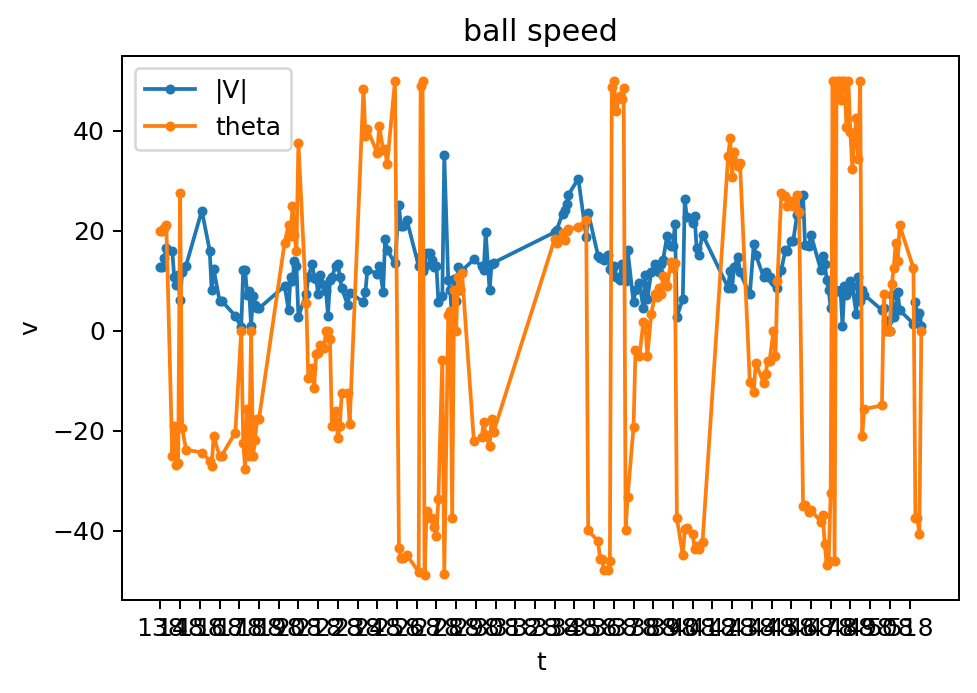

In [97]:
import cmath
hits = []
wall = []
bounce = []

ball_t = [int(t) for t in ball_pos.keys() if len(ball_pos[t][0])>2 and t in range(138,525)]
ball_v_x = [ball_pos[t][0][2][0] for t in ball_t if len(ball_pos[t][0])>2]
ball_v_y = [ball_pos[t][0][2][1] for t in ball_t if len(ball_pos[t][0])>2]
ball_v = [math.sqrt(x*x+y*y) for x,y in zip(ball_v_x, ball_v_y)]
ball_o = [cmath.polar(complex(x,y))[1]*100/(2*math.pi) for x,y in zip(ball_v_x, ball_v_y)]

to_delete = []

for i in range(1,len(ball_t)-1):
  if (ball_v[i] < ball_v[i-1]-8 and ball_v[i] < ball_v[i+1]-8) or ball_v[i]>50:
    to_delete.append(i)
print(to_delete)

ball_t = [ball_t[i] for i in range(len(ball_t)) if i not in to_delete]
ball_v_x = [ball_v_x[i] for i in range(len(ball_v_x)) if i not in to_delete]
ball_v_y = [ball_v_y[i] for i in range(len(ball_v_y)) if i not in to_delete]
ball_v = [ball_v[i] for i in range(len(ball_v)) if i not in to_delete]
ball_o = [ball_o[i] for i in range(len(ball_o)) if i not in to_delete]


print(list(zip(range(len(ball_v)), ball_v)))


import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180

radians = True
if radians:
  plt.plot(ball_t, ball_v, label="|V|", marker='.')
  plt.plot(ball_t, ball_o, label="theta", marker='.')
else:
  plt.plot(ball_t, ball_v_x, label="V_x", marker='.')
  plt.plot(ball_t, ball_v_y, label="V_y", marker='x')
plt.xticks(np.arange(min(ball_t), max(ball_t)-1, 10))
for b in bounce:
  plt.axvline(x=b, color='b')
for h in hits:
  plt.axvline(x=h, color='r')
for w in wall:
  plt.axvline(x=w, color='g')

plt.plot()

plt.xlabel("t")
plt.ylabel("v")
plt.title("ball speed")
plt.legend()
plt.axes().xaxis.grid(True, which='minor')
plt.show()

# Imprimir resultado a video

In [ ]:
import cv2
def plot_players(img, players):
  i = 1
  for p in players:
    img = cv2.rectangle(img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (255,0,0), 2)
    cv2.putText(img, str(int(p[5])), (int(p[2]),int(p[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (10, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(img, str(round(p[-1],2)), (int((p[2]+p[0]-6)/2),int(p[1]-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (10, 255, 0), 1, cv2.LINE_AA)
    i += 1
  return img

def plot_ball(img, ball):
  center = (int(ball[0]), int(ball[1]))
  img = cv2.circle(img, center, 5, (0,0,255), 2)
  if len(ball)>2:
    speed = (int(ball[0]+1.5*ball[2][0]), int(ball[1]+1.5*ball[2][1]))
    img = cv2.arrowedLine(img, center, speed, (0,0,200), 2)
  return img

#players_box = [[p['bbox'] for p in per] for per in person_results]

video_path = path+input_name+'.mp4'
out_video_root = path+'vis_'+input_name+'.mp4'
print(out_video_root)
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
videoWriter = cv2.VideoWriter(out_video_root, fourcc, fps, size)
i = 0
while (cap.isOpened()):
        flag, img = cap.read()
        if not flag:
            break
        #modify img
        vis_img = img
        if not i%10:
          vis_img, camera_flag = is_central_camera(vis_img)
        if camera_flag:
          cv2.putText(vis_img, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (10, 255, 0), 1, cv2.LINE_AA)
          vis_img = plot_court(vis_img)
          if i < len(players_box):
            vis_img = plot_players(vis_img, players_box[i])
          if i in ball_pos:
            vis_img = plot_ball(vis_img, ball_pos[i][0])
        else:
          cv2.putText(vis_img, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (153, 0, 0), 1, cv2.LINE_AA)

        #save img
        videoWriter.write(vis_img)
        i += 1
cap.release()
videoWriter.release()

### Analisis golpes

In [3]:
from DLT import *
# Known 3D coordinates
xyz = [[-875, 0, 9.755], [442, 0, 9.755], [1921, 0, 9.755], [2951, 0.5, 9.755], [-4132, 0.5, 23.618],[-876, 0, 23.618]]
    # Known pixel coordinates
uv = [[76, 706], [702, 706], [1440, 706], [1867, 706], [264, 523], [625, 523]]

nd = 3
P, err = DLTcalib(nd, xyz, uv)
print('Matrix')
print(P)
print('\nError')
print(err)


[ 6.15603884e-01 -4.13878048e+02 -2.00661317e+01 -4.95516949e-01
 -1.33390601e-03 -8.68639595e+00 -5.95810574e+01 -1.51304061e-01
 -1.00624568e-02 -6.55267186e+01  1.60533207e+02  1.00000000e+00]
[[ 6.15603884e-01 -4.13878048e+02 -2.00661317e+01 -4.95516949e-01]
 [-1.33390601e-03 -8.68639595e+00 -5.95810574e+01 -1.51304061e-01]
 [-1.00624568e-02 -6.55267186e+01  1.60533207e+02  1.00000000e+00]]
[[ 2.08864341e-01 -1.85950110e+02  9.40861494e+01 -7.00800455e+02]
 [-5.39689559e-03 -3.51445840e+01  5.78328574e+01 -2.50683573e+02]
 [-7.64432802e-06 -4.97798641e-02  1.21955157e-01 -7.45655624e-01]]
Matrix
[[-2.80108315e-01  2.49378002e+02 -1.26179092e+02  9.39844658e+02]
 [ 7.23778566e-03  4.71324602e+01 -7.75597415e+01  3.36192157e+02]
 [ 1.02518211e-05  6.67598587e-02 -1.63554264e-01  1.00000000e+00]]

Error
2.578845649359634e-10


In [ ]:
pip install keras-ocr

In [111]:
input_name = 'Final_PremiereQatar_2_21'# 'punto_qatar'#
import cv2
vidcap = cv2.VideoCapture(path+input_name+'.mp4')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
      #image = image[25:100, 90:370]
      cv2.imwrite(path+str(sec)+" frame.png", image)     # save frame as PNG file
    return hasFrames
getFrame(10)

True

In [ ]:
#Importing the library
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()



(1080, 1920, 3)
different dimensions



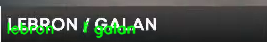

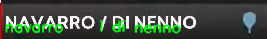

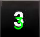

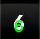

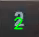

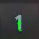

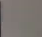

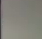

[[['lebron', 'galan', 'f'], '3', '2'], ['navarro', 'di', 'nenno', 'l']]


In [121]:
def parse_marcador(pipeline, frame, debug=False):
  import numpy as np
  import cv2
  from google.colab.patches import cv2_imshow # for image display

  box = [[98,25, 276,53, 0], [98,53, 276,79, 0], [276,28, 303,53, 0], [276,53, 303,79, 0], [303,28, 329,53, 0], [303,53, 329,79, 0], [329,28, 357,53, 1], [329,53, 357,79, 1] ]
  dim = [720, 1280]#[1080, 1920]
  if dim[0]!=frame.shape[0] or dim[1]!=frame.shape[1]:
    print("different dimensions")
    r_x, r_y = frame.shape[1]/dim[1], frame.shape[0]/dim[0]
    box = [[int(b[0]*r_x), int(b[1]*r_y), int(b[2]*r_x), int(b[3]*r_y), b[4]] for b in box]
  images = [frame[b[1]:b[3], b[0]:b[2]] for b in box]
  inv_images = [cv2.bitwise_not(img) for img in images]
  prediction_groups = pipeline.recognize(images)
  prediction_groups_inv = pipeline.recognize(inv_images)

  if debug:
    for pred, pred_i, img in zip(prediction_groups, prediction_groups_inv, images):
      print("")
      for p in pred+pred_i:
        cv2.putText(img, str(p[0]), (int(p[1][3][0]),int(p[1][3][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (10, 255, 0), 1, cv2.LINE_AA)
      cv2_imshow(img)
  
  return [[[p[0] for p in prediction_groups[0]], prediction_groups[2][0][0], prediction_groups[4][0][0]], \
          [p[0] for p in prediction_groups[1]] ]

# Get a set of three example images
#image = keras_ocr.tools.read(path+'100 frame.png')

frame = keras_ocr.tools.read(path+'10 frame.png')
print(frame.shape)
print(parse_marcador(pipeline, frame , True))